In [2]:
import PIL.Image as pil_image
import glob
import json
from collections import defaultdict
import scipy.io
import numpy as np
import os
import random
%matplotlib inline
import matplotlib.pyplot as plt
from myutil import *

import keras
from keras.utils import np_utils
from keras.models import load_model,Model
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [3]:
# setting
#(img_height, img_width)
crop_size = (224, 224)
data_dir = './start/'
shuffle = True
alpha = 0.5
model_name = ''
bb_list = np.load('./start/bba/bball.npy').item()

## Utils

In [4]:
def original(img):
    """
    return the original pic
    """
    tmp = np.zeros_like(img)
    for i in range(3):
        tmp[:,:,i] = img[:,:,i] - img[:,:,i].min()
    return tmp.astype(np.uint8)

def lookup(d, key, i):
    """
    looking up key value i in dictionary d 
    """
    if key == 'make+model':
        for item in d:
            if item['pp_brand_id']+' '+item['pp_genre_id'] == i:
                return item['chinese']
    else:
        for item in d:
            if item[key] == i:
                return item['chinese']
            
def crop_img(img, box):
    """
    box: left, top, right, bottom
    """
    w, h = img.size
    box = [box[0]*w, box[1]*h,box[2]*w,box[3]*h]
    return img.crop(box)
            
def load_img(path, grayscale=False, target_size=None, box=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        box: The crop rectangle, as a (left, upper, right, lower)-tuple.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if box:
        img = crop_img(img, box)
        
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        #resize(w, h)
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img
            
def load_data(image_paths, labels, num_of_class=10, target_size=(227, 227), box=None):
    """
    Given list of paths, resize and bounding box load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
        box:[top, left, bottom, right]
    :return X: image array
     return y: one hot encoded labels
    """
    if box:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        ## google output box :## 0: top 1: left 2 lower 3 right
        for i,path in enumerate(image_paths):
            new_box = (box[i][1],box[i][0],box[i][3], box[i][2])
            X[i, :] = img_to_array(load_img(path, target_size=crop_size, box=new_box))
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    else:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        for i,path in enumerate(image_paths):
            X[i, :] = img_to_array(load_img(path, target_size=crop_size))
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    
def load_data_flip(image_paths, labels, num_of_class=10, target_size=(227, 227), box=None):
    """
    Given list of paths, resize and bounding box load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
        box:[top, left, bottom, right]
    :return X: image array
     return y: one hot encoded labels
    """
    if box:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        ## google output box :## 0: top 1: left 2 lower 3 right
        for i,path in enumerate(image_paths):
            new_box = (box[i][1],box[i][0],box[i][3], box[i][2])
            if bool(random.getrandbits(1)):
                X[i, :] = img_to_array(load_img(path, target_size=crop_size, box=new_box))
            else: 
                X[i, :] = img_to_array(load_img(path, target_size=crop_size, box=new_box))[:,::-1,:]
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    else:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        for i,path in enumerate(image_paths):
            if bool(random.getrandbits(1)):
                X[i, :] = img_to_array(load_img(path, target_size=crop_size))
            else: 
                X[i, :] = img_to_array(load_img(path, target_size=crop_size))[:,::-1,:]
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    
def judge_box(left, right, left_t=0.5, right_t=0.5):
    if left < left_t and right > right_t:
        return True

def load_box(path='./start/bba/bball.npy',x_threshold=0.5,x_threshold2=0.5):
    if x_threshold > x_threshold2:
        print 'threshold error'
    with open(path) as f:
        bb_list = np.load(f).item()
    result = defaultdict(list)
    ## delete left > 0.5 right border < 0.5
    ## 0: top 1: left 2 lower 3 right
    for k in bb_list.keys():
        if len(bb_list[k]) == 1:
            result[k] = bb_list[k]
            continue
        for bb_box in bb_list[k]:
            if judge_box(left=bb_box[1], right=bb_box[3], left_t=x_threshold, right_t=x_threshold2):
                result[k].append(bb_box)
    return result


## Loading data

In [5]:
train_paths = []
train_labels = defaultdict(list)
train_makes = []
train_models = []
train_types = []

val_paths = []
val_labels = defaultdict(list)
val_makes = []
val_models = []
val_types = []
# indentify make/model/car_id.jpg
brands = os.listdir(data_dir)
brands.remove('bba')
brands = [ '1', '10', '11', '12', '13', '15', '16', '18', '21', '22', '26', '27', '29', '30', '31', '43', '45', '48', '49', '53']
for brand in brands:
    genres = os.listdir(os.path.join(data_dir, brand))
    for genre in genres:
        pics = glob.glob(os.path.join(data_dir, brand, genre)+'/*_b.jpg')
        if len(pics)<3:
            continue
        split = len(pics)*4/5
        # train data
        for pic in pics[:split]:
            # two pic in a row
            train_paths += [pic[:-6] + '.jpg' + ' ' + pic]
            # label|
            train_models += [brand + ' ' +genre]
            train_makes += [brand]
        
        #validation data
        for pic in pics[split:]:
            # two pic in a row
            val_paths += [pic[:-6] + '.jpg' + ' ' + pic]
            # label|
            val_models += [brand + ' ' +genre]
            val_makes += [brand]

assert(len(train_makes) == len(train_paths))

#indexing building
l2i_makes = sorted(list(set(train_makes + ['-1'])))
l2i_models = sorted(list(set(train_models + ['-1'])))

# for multiple label
train_labels[0] = np.array([l2i_makes.index(item) for item in train_makes])
train_labels[1] = np.array([l2i_models.index(item) for item in train_models])

val_labels[0] = np.array([l2i_makes.index(item) for item in val_makes])
val_labels[1] = np.array([l2i_models.index(item) for item in val_models])

if shuffle == True :
    idx = list(range(len(train_labels[0])))
    random.shuffle (idx)
    train_paths = np.array(train_paths)
    train_labels[0] = train_labels[0][idx]
    train_labels[1] = train_labels[1][idx]
    train_paths = train_paths[idx]

# data info
num_of_models = len(l2i_models)
num_of_makes = len(l2i_makes)
num_of_train = len(train_labels[0])

#saving mapping info
np.save('./start/bba/l2i_makes.npy',l2i_makes)
np.save('./start/bba/l2i_models.npy',l2i_models)

##genere list
genre_list = [json.loads(line) for line in open('./start/bba/genre_list.json')][0]

## box_list
box_list =load_box()
print l2i_makes


['-1', '1', '10', '11', '12', '13', '15', '16', '18', '21', '22', '26', '27', '29', '30', '31', '43', '45', '48', '49', '53']


In [6]:
front_path = [p.split(' ')[0] for p in train_paths]
back_path = [p.split(' ')[1] for p in train_paths]
for item in back_path:
    if '/'.join(item.split('/')[-3:]) not in box_list.keys():
        print '/'.join(item.split('/'))
        
print 'checking bounding box complete'
for key in box_list.keys():
    if len(box_list[key])==0:
        print key

checking bounding box complete


In [6]:
## Caltech 256 except 252 car side
train_negative = []
cal_path = glob.glob('/root/playground/START/car_class/256_ObjectCategories/*')
for item in cal_path:
    train_negative += glob.glob(item + '/*.jpg')
    
random.shuffle(train_negative)
train_negative = train_negative
negative_label = [[0]*len(train_negative), [0]*len(train_negative)]

In [7]:
print len(train_labels[0]), len(train_negative)

17182 30491


In [19]:
for brand in brands:
    genres = os.listdir(os.path.join(data_dir, brand))
    for genre in genres:
        pics = glob.glob(os.path.join(data_dir, brand, genre)+'/*_b.jpg')
        print lookup(bba_info, 'pp_genre_id', genre), genre_list[genre]['name'], genre, brand, len(pics)
        

大众 开迪 5 1 1
大众 甲壳虫 426 1 49
大众 高尔夫 20159 1 6
大众 途安 47 1 66
大众 高尔 243 1 1
大众 POLO三厢 2472 1 34
大众 速腾 16 1 263
大众 桑塔纳志俊 50 1 35
大众 朗逸 49 1 337
大众 桑塔纳3000 1218 1 10
大众 帕萨特领驭 2434 1 100
大众 桑塔纳 20241 1 4
大众 帕萨特 52 1 213
大众 POLO GTI 2461 1 3
大众 宝来 20 1 308
大众 尚酷 416 1 22
大众 桑塔纳·尚纳 1135 1 65
大众 奕鸥EOS 447 1 2
大众 POLO两厢 48 1 199
大众 辉腾 412 1 1
大众 桑塔纳·浩纳 1136 1 10
大众 CC 1 1 76
大众 朗行 57 1 46
大众 Tiguan 1306 1 6
大众 途锐 446 1 1
大众 凌渡 54 1 22
大众 捷达 17 1 215
大众 迈特威 1139 1 2
大众 夏朗 439 1 9
大众 桑塔纳经典 20262 1 2
大众 朗境 53 1 2
大众 CROSS POLO 2459 1 21
大众 高尔夫嘉旅 20315 1 1
大众 高尔夫 22 1 184
大众 迈腾 20244 1 1
大众 迈腾 20010 1 253
大众 高尔夫R敞篷 20309 1 1
大众 VARIANT 20141 1 4
大众 途观 51 1 101
大众 高尔夫GTI 20173 1 8
斯柯达 速派 20021 10 11
斯柯达 速派 76 10 1
斯柯达 明锐 62 10 177
斯柯达 速尊 683 10 1
斯柯达 昊锐 69 10 48
斯柯达 昕动 78 10 9
斯柯达 明锐经典款 2454 10 9
斯柯达 晶锐SCOUT 2455 10 1
斯柯达 Yeti 685 10 6
斯柯达 昕锐 75 10 31
斯柯达 明锐RS 2453 10 2
斯柯达 晶锐 20019 10 79
奥迪 Q7 86 11 3
奥迪 S3 1067 11 3
奥迪 A6 38 11 1
奥迪 A3掀背 2507 11 4
奥迪 Q3 85 11 2
奥迪 A5敞篷 2439 11 1
奥迪 A3三厢 20024 11 36

## Build Model

In [12]:
#def load_data(image_paths, labels, num_of_class=10, target_size=(227, 227), box=None):

def generate_arrays(batch_size, target_size = (224,224)):
    sample_number = len(train_paths)
    front_path = [p.split(' ')[0] for p in train_paths]
    front_box = [ box_list['/'.join(item.split('/')[-3:])][0] for item in front_path ]
    back_path = [p.split(' ')[1] for p in train_paths]
    back_box = [ box_list['/'.join(item.split('/')[-3:])][0] for item in back_path ]
    while True:
        for i in range(0,sample_number,batch_size):
            if i + batch_size > sample_number:
                X_train, y_train = load_data_flip(front_path[i:], train_labels[0][i:], num_of_makes, target_size, front_box[i:])
                X_train2, y_train2 = load_data_flip(back_path[i:], train_labels[1][i:], num_of_models, target_size, back_box[i:])
            else:
                X_train, y_train = load_data_flip(front_path[i:i+batch_size], train_labels[0][i:i+batch_size], num_of_makes,target_size, front_box[i:i+batch_size])
                X_train2, y_train2 = load_data_flip(back_path[i:i+batch_size], train_labels[1][i:i+batch_size],num_of_models,target_size, back_box[i:i+batch_size])
            X_train = preprocess_input(X_train)
            X_train2 = preprocess_input(X_train2)
            ## no car pic
            X_negative, y_negative = load_data(train_negative[i:i+2], negative_label[0][i:i+2], num_of_makes, target_size)
            y_negative2 = np_utils.to_categorical(negative_label[0][i:i+2], num_of_models)
            #yield (X_train, {'make':y_train, 'model':y_train2})
            yield (np.concatenate((X_train, X_train2, X_negative), axis=0), 
                   {'make':np.concatenate((y_train,y_train, y_negative), axis=0), 
                    'model':np.concatenate((y_train2,y_train2,y_negative2),axis=0)}
                  )
            #yield (np.concatenate((X_train, X_train2), axis=0), 
            #      {'make':np.concatenate((y_train,y_train), axis=0), 
            #        'model':np.concatenate((y_train2,y_train2),axis=0)}
            #      )

def get_model4( output_dim, make_num =11,alpha=0.5):
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=True)
    vgg_out = base_model.layers[-2].output #Last FC layer's output 
    
    # output multiple label
    pred_make = Dense(make_num, activation='softmax', name='make')(vgg_out)
    pred_model = Dense(output_dim, activation='softmax', name='model')(vgg_out)
    
    
    model = Model(inputs=base_model.input, outputs=[pred_make, pred_model])
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    
    model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
              loss={'make':'categorical_crossentropy', 'model':'categorical_crossentropy'},
              loss_weights={'make': alpha, 'model': 1-alpha},
              metrics=['accuracy'])
    return model

def get_transfer_model(output_dim, alpha=0.5):
    model = load_model('./model/good/yiche_1581_0.88.hdf5')
    for layer in model.layers:
        layer.trainable = False
    fc2 = model.get_layer('dropout_2')
    vgg_out = fc2.output
    # output multiple label
    pred_make = Dense(output_dim[0], activation='softmax', name='make')(vgg_out)
    pred_model = Dense(output_dim[1], activation='softmax', name='model')(vgg_out)
    return Model(inputs=model.input, outputs=[pred_make, pred_model])

## training

In [13]:
model = get_transfer_model([num_of_makes,num_of_models])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928                                        
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0                                            
___________________________________________________________________________________________

In [14]:
#X_val, y_val = load_data(val_paths, val_labels, crop_size)

front_path_val = [p.split(' ')[0] for p in val_paths]
front_box_val = [ box_list['/'.join(item.split('/')[-3:])][0] for item in front_path_val ]
back_path_val = [p.split(' ')[1] for p in val_paths]
back_box_val = [ box_list['/'.join(item.split('/')[-3:])][0] for item in back_path_val ]
tmp1, y = load_data(front_path_val, val_labels[0], num_of_makes, crop_size, front_box_val)
tmp2, y2 = load_data(back_path_val, val_labels[1], num_of_models, crop_size, back_box_val)
tmp1 = preprocess_input(tmp1)
tmp2 = preprocess_input(tmp2)
X_val = [tmp1,tmp2]
y_val = [y,y2]


In [ ]:
checkpointer = ModelCheckpoint(filepath='./model/start_using_yiche_feature.{epoch:02d}-{model_acc:.2f}-{val_model_acc:.2f}.hdf5', period = 1)

#model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
#             optimizer=optimizers.RMSprop(lr=0.1))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001,momentum=0.9))
#model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
#              loss={'make':'categorical_crossentropy', 'model':'categorical_crossentropy'},
#              loss_weights={'make': 0.5, 'model': 0.5},
#              metrics=['accuracy'])
model.fit_generator(generate_arrays(batch_size=40,target_size=crop_size),
                    validation_data=(X_val[0], y_val),
                    steps_per_epoch=len(train_labels[0]) / 40, epochs=100,
                   callbacks=[checkpointer])


## predict using bb

In [1]:
import numpy as np
import os
import tensorflow as tf
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image as pil_image
from myutil import *
from keras.models import load_model
from io import open
import json
from keras.applications.imagenet_utils import preprocess_input

#'./model/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
class genre_m:
    def __init__(self, path_ssd, path_pred):
        self.path_ssd = path_ssd
        self.path_pred = path_pred
        self.detection_graph = tf.Graph()
        self.load_weight()
        self.pred_model = load_model(path_pred)
        print 'load model complete....'
        self.bba_info = [json.loads(line) for line in open('/root/playground/START/car_class/start/bba/20car.json',encoding='gbk')]
        self.genre_list = [json.loads(line) for line in open('/root/playground/START/car_class/start/bba/genre_list.json')][0]
        self.l2i_models = np.load('/root/playground/START/car_class/model/good/224_224_w_box_l2i_models.npy')
        print 'load car info complete...'
        self.img = []
        self.box = []
        #self.image_size = (12, 8)

    def load_weight(self):
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_ssd, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')       
        
        
    def predict(self, path, target_size=(224,224)):
        self.img = pil_image.open(path)
        box = self.extract_bb(img_list=[self.img])
        
        ## google output box :## 0: top 1: left 2 lower 3 right
        w, h = self.img.size
        print 'image size w*h:',w, h
        box = [box[1]*w, box[0]*h,box[3]*w,box[2]*h]
        self.img = self.img.crop(box)
        plt.imshow(self.img)
        self.img = self.img.resize(target_size)
        img_np = img_to_array(self.img)
        img_np = preprocess_input(np.expand_dims(img_np, axis=0))
        print 'img preprocess complete. ready for classification'
        #ready for classification
        ress = self.pred_model.predict(img_np)
        brand =[]
        for i in range(1):
            #res1 = ress[0][i]
            res2 = ress[1][i]
            #top1 = res1.argsort()[-5:][::-1]
            top2 = res2.argsort()[-5:][::-1]
            for i in range(5):
                #item1 = top1[i]
                item2 = top2[i]
                #m_t = str(l2i_makes[item1])
                m_m_t = str(self.l2i_models[item2])
                brand.append({'b':lookup(self.bba_info, 'pp_genre_id', m_m_t.split(' ')[1]),
                              'pp_brand_id':self.genre_list[m_m_t.split(' ')[1]]['name'],
                              'score':res2[top2[i]]})
            return brand
        
    def extract_bb(self, img_list):
        with self.detection_graph.as_default():
            with tf.Session(graph=self.detection_graph) as sess:
                for image in img_list:
                    image_np = img_to_array(image)
                        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
                        # Each box represents a part of the image where a particular object was detected.
                    boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
                        # Each score represent how level of confidence for each of the objects.
                        # Score is shown on the result image, together with the class label.
                    scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
                    classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
                    num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
                        # Actual detection.
                    (boxes, scores, classes, num_detections) = sess.run(
                            [boxes, scores, classes, num_detections],
                            feed_dict={image_tensor: image_np_expanded})
                    bb_car = []
                    for i in range(11):
                        if scores[0][i] < 0.5:
                            if len(bb_car) == 0:
                                print 'no car detected'
                                bb_car.append('error')
                            break
                        elif classes[0][i] == 8. or classes[0][i] == 3.:
                            if judge_box(boxes[0][i][1], boxes[0][i][3]):
                                bb_car.append(boxes[0][i])
                    return np.array(bb_car[0])
    

Using TensorFlow backend.


In [2]:
test = genre_m(path_ssd='./model/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb', path_pred='./model/good/224_224_w_box_vgg.11-1.12.hdf5')


load model complete....
load car info complete...


image size w*h: 1200 800
img preprocess complete. ready for classification
帕萨特 大众 0.619135
宝来 大众 0.274513
CC 大众 0.0402581
帕萨特领驭 大众 0.0147287
凌渡 大众 0.0110638


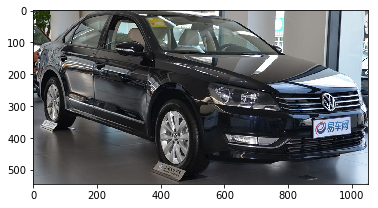

In [11]:
res = test.predict('./test_img/11385674312393_3459563_16.jpg')
for item in res:
    print item['pp_brand_id'], item['b'], item['score']